In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats as sts

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()

import os
import glob

%matplotlib inline

## Data

35 по phi, 5 по p

10 по v, 40 по p

In [2]:
data = pd.DataFrame(np.vstack([pd.read_csv(f'data_sparse/{fname}').drop('t', 1).values \
                               for fname in os.listdir('data_sparse') if fname != '.DS_Store']),
                    columns=['v', 'phi', 'p', 'q'])

In [3]:
data_test = pd.DataFrame(np.vstack([pd.read_csv(f'data_test/{fname}').drop('t', 1).values \
                                    for fname in os.listdir('data_test') if fname != '.DS_Store']),
                         columns=['v', 'phi', 'p', 'q'])

In [5]:
plt.rc('xtick', labelsize='xx-large') 
plt.rc('ytick', labelsize='xx-large')

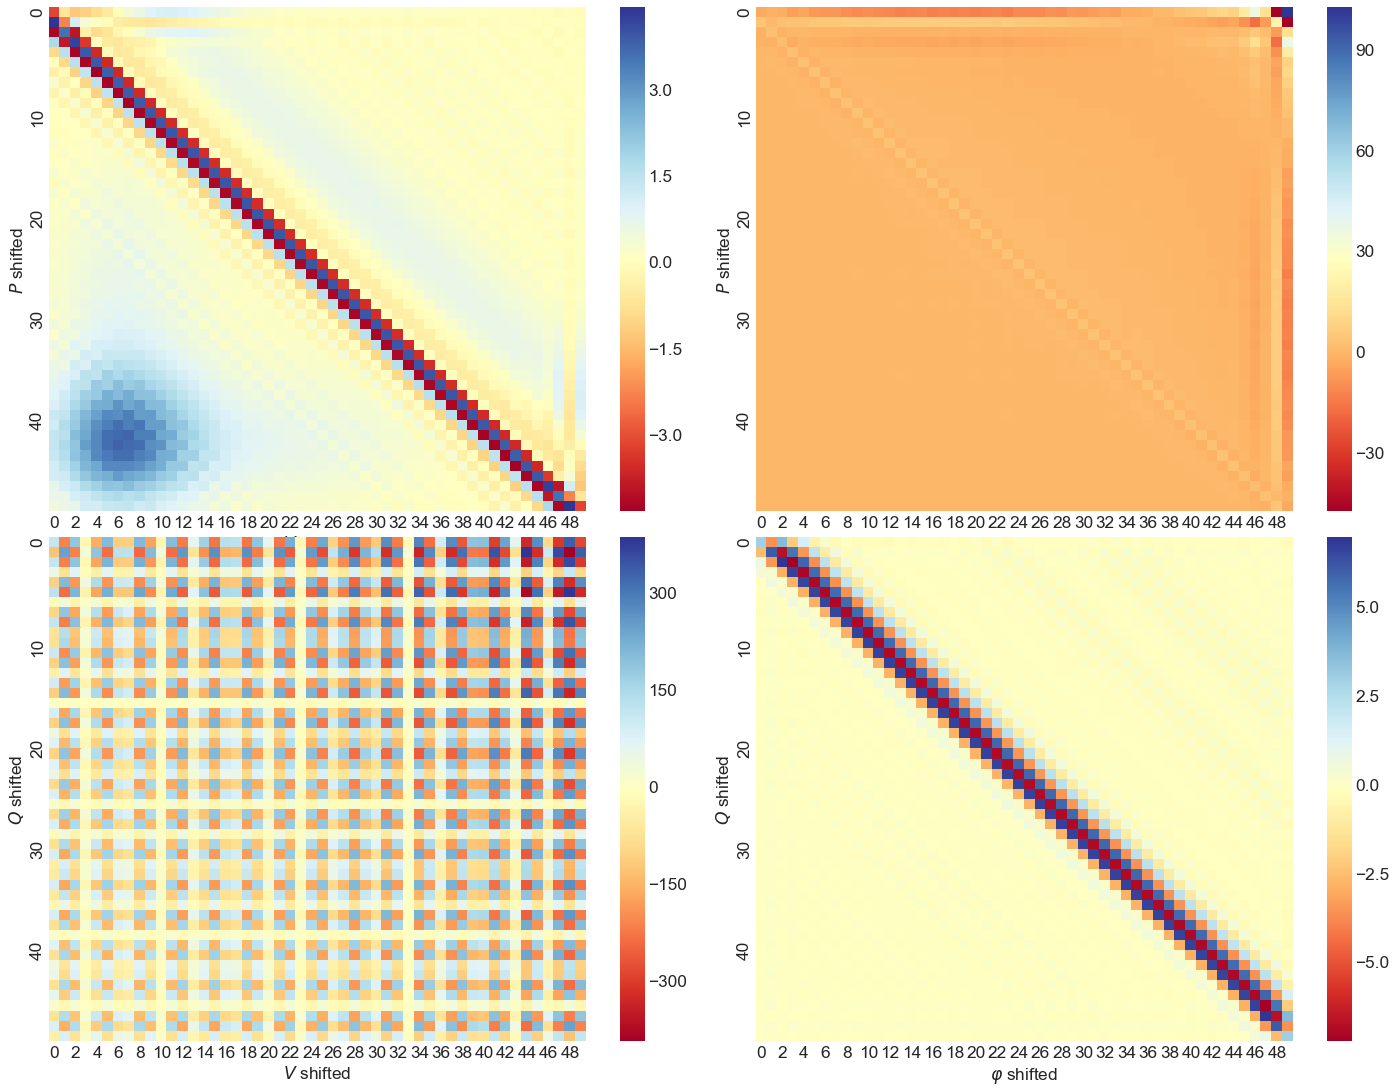

In [12]:
fig, axes = plt.subplots(2, 2, True, True, figsize=(20,15))
fig.tight_layout()
for ax, pair, pairview in zip(axes.flatten(),
                              [('p', 'v'), ('p', 'phi'), ('q', 'v'), ('q', 'phi')],
                              [('$P$', '$V$'), ('$P$', '$\\varphi$'), ('$Q$', '$V$'), ('$Q$', '$\\varphi$')]):
    mtx = np.array([[data[pair[0]].shift(x).corr(data[pair[1]].shift(y)) for y in range(50)] for x in range(50)])
    mtx_inv = np.linalg.inv(mtx)
    sns.heatmap(mtx_inv, cmap='RdYlBu', ax=ax, yticklabels=10)
    ax.set_xlabel(pairview[1] + ' shifted', fontsize='xx-large')
    ax.set_ylabel(pairview[0] + ' shifted', fontsize='xx-large')

In [ ]:
data = [pd.read_csv(f'data_sparse/{fname}').drop('t', 1) \
        for fname in os.listdir('data_sparse') if fname != '.DS_Store']

In [ ]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(20,20))
varnames = ['$V$', '$\\varphi$', '$P$', '$Q$']
varidx = ['v', 'phi', 'p', 'q']
for i, (iname, iidx, axrow) in enumerate(zip(varnames, varidx, axes)):
    for j, (jname, jidx, ax) in enumerate(zip(varnames, varidx, axrow)):
        lags = range(1, 150)
        corrs_all = list()
        for df in data:
            corrs = list()
            for lag in lags:
                corrs.append(df[iidx].corr(df[jidx].shift(lag)))
            corrs_all.append(corrs)
        corrs = np.sum(corrs_all, axis=0) / len(data)
        ax.plot(lags, corrs)
        bounds = ax.get_xbound()
        ax.hlines([sts.norm.cdf(0.95), -sts.norm.cdf(0.95)] / np.sqrt(len(data)),
                  *ax.get_xbound())
        ax.hlines([sts.norm.cdf(0.99), -sts.norm.cdf(0.99)] / np.sqrt(len(data)),
                  *ax.get_xbound(), linestyles='dashed')
        ax.vlines(30, sts.norm.cdf(0.99) / np.sqrt(len(data)), -sts.norm.cdf(0.99) / np.sqrt(len(data)), 'r')
        if i == 3:
            ax.set_xlabel('Lag')
        if j == 0:
            ax.set_ylabel('Correlation')
        ax.set_title(iname + ' / ' + jname)
        ax.set_xlim(bounds)

## ARIMA

In [9]:
data['phiD'] = data['phi'].diff()

In [24]:
data_test['phiD'] = data_test['phi'].diff()

In [10]:
data['vD'] = data['v'].diff()

In [25]:
data_test['vD'] = data_test['v'].diff()

In [12]:
data = data.dropna()

In [26]:
data_test = data_test.dropna()

In [31]:
m = sm.tsa.ARIMA(endog=data['p'].values, exog=data['phiD'].values, order=(30, 0, 0))

In [27]:
m_test = sm.tsa.ARIMA(endog=data_test['p'].values, exog=data_test['phiD'].values, order=(10, 0, 0))

In [32]:
%%time
results_30 = m.fit()

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


CPU times: user 2h 43min 58s, sys: 3min 43s, total: 2h 47min 42s
Wall time: 2h 11min 32s


/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


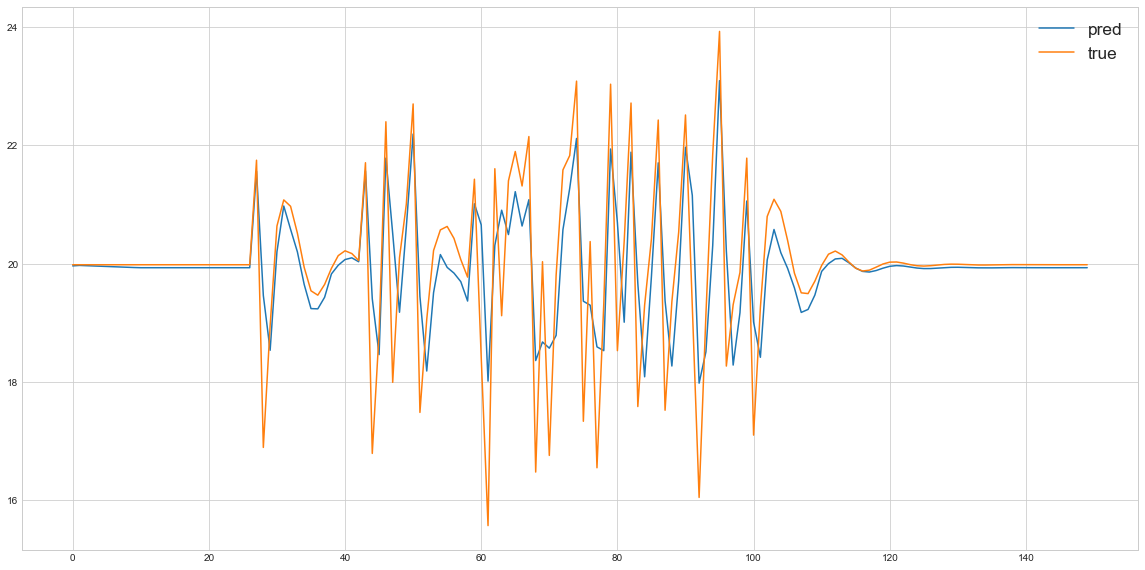

In [30]:
# AM (10, 0, 0)
plt.figure(figsize=(20,10))
plt.plot(m.predict(results_10.params)[:150], label='pred')
plt.plot(data['p'].values[:150], label='true')
plt.legend(loc='best', fontsize='xx-large')

In [28]:
err = [np.sqrt(np.sum((t - p) ** 2)) / np.sqrt(np.sum(t ** 2)) \
       for t, p in zip(data['p'].values[:len(data['p'].values) // 151 * 151].reshape((len(data['p'].values) // 151, 151)),
                       m.predict(results_10.params)[:len(data['p'].values) // 151 * 151].reshape((len(data['p'].values) // 151, 151)))]

AttributeError: 'ARMA' object has no attribute 'k_trend'

In [21]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(err).round(4),
                 'median %.4f' % np.median(err).round(4),
                 'max %.4f' % np.max(err).round(4),
                 'min %.4f' % np.min(err).round(4),
                 '95%% percentile %.4f' % np.percentile(err, 95).round(4)]))

RMSE
mean 0.0536
median 0.0590
max 0.0900
min 0.0079
95% percentile 0.0752


/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


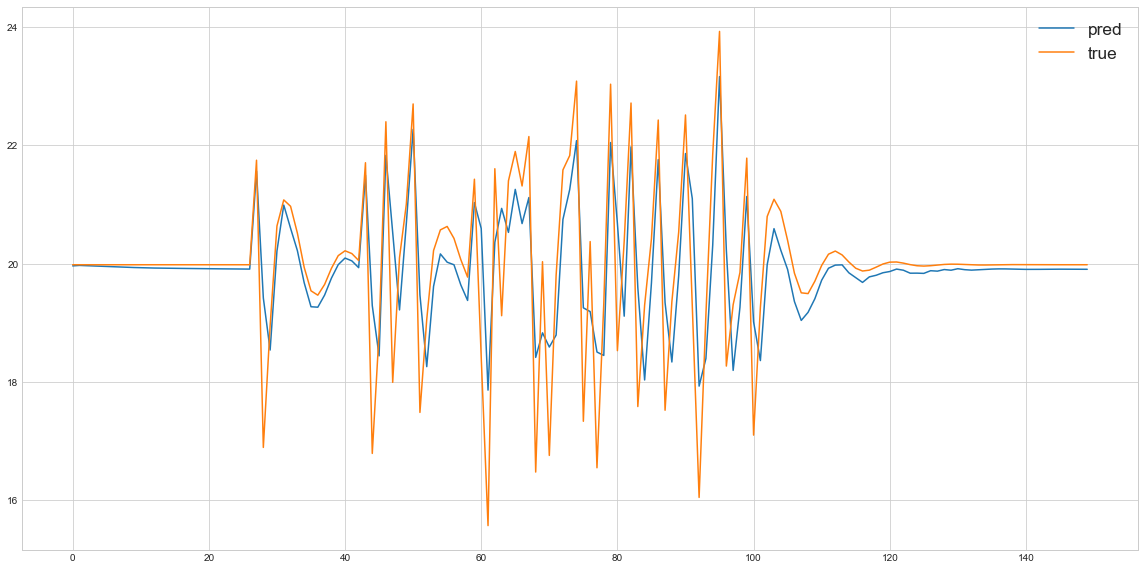

In [33]:
# AM (30, 0, 0)
plt.figure(figsize=(20,10))
plt.plot(m.predict(results_30.params)[:150], label='pred')
plt.plot(data['p'].values[:150], label='true')
plt.legend(loc='best', fontsize='xx-large')

In [34]:
err = [np.sqrt(np.sum((t - p) ** 2)) / np.sqrt(np.sum(t ** 2)) \
       for t, p in zip(data['p'].values[:len(data['p'].values) // 151 * 151].reshape((len(data['p'].values) // 151, 151)),
                       m.predict(results_30.params)[:len(data['p'].values) // 151 * 151].reshape((len(data['p'].values) // 151, 151)))]

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [35]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(err).round(4),
                 'median %.4f' % np.median(err).round(4),
                 'max %.4f' % np.max(err).round(4),
                 'min %.4f' % np.min(err).round(4),
                 '95%% percentile %.4f' % np.percentile(err, 95).round(4)]))

RMSE
mean 0.0532
median 0.0591
max 0.0892
min 0.0086
95% percentile 0.0749
